## Implementation using TensorFlow on fashion minst dataset.

In [ ]:
! pip install -U "ray[data,train,tune,serve]"

In [2]:
import ray
from ray import tune, train
from ray.tune import grid_search
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist

In [4]:
ray.init()

2024-02-21 10:01:44,790	INFO worker.py:1715 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8266 


Python version:,3.11.5
Ray version:,2.9.2
Dashboard:,http://127.0.0.1:8266


(raylet) [2024-02-21 10:01:54,832 E 72757 222050] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-02-21_10-01-42_582128_72639 is over 95% full, available space: 10926469120; capacity: 245107195904. Object creation will fail if spilling is required.
(raylet) [2024-02-21 10:02:04,931 E 72757 222050] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-02-21_10-01-42_582128_72639 is over 95% full, available space: 10926469120; capacity: 245107195904. Object creation will fail if spilling is required.
(raylet) [2024-02-21 10:02:15,029 E 72757 222050] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-02-21_10-01-42_582128_72639 is over 95% full, available space: 10925916160; capacity: 245107195904. Object creation will fail if spilling is required.
(raylet) [2024-02-21 10:02:25,124 E 72757 222050] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-02-21_10-01-42_582128_72639 is over 95% full, available space: 10925928448; capacity: 245107195904. Object crea

In [5]:
# Define a function to train the model
def train_model(config):
    # Load and preprocess the Fashion MNIST dataset
    (X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
    X_train, X_test = X_train / 255.0, X_test / 255.0  # Normalize pixel values

    # Define a TensorFlow model
    model = tf.keras.Sequential(
        [
            tf.keras.layers.Flatten(input_shape=(28, 28)),
            tf.keras.layers.Dense(config["units_1"], activation="relu"),
            tf.keras.layers.Dropout(config["dropouts_1"]),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(config["units_2"], activation="relu"),
            tf.keras.layers.Dropout(config["dropouts_2"]),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(10, activation="softmax"),
        ]
    )

    # Compile the model
    optimizer = tf.keras.optimizers.Adam()
    model.compile(
        optimizer=optimizer,
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )

    # Train the model
    model.fit(X_train, y_train, epochs=5, verbose=0)

    # Evaluate the model
    _, test_accuracy = model.evaluate(X_test, y_test)
    train.report({"test_accuracy": test_accuracy})

(raylet) [2024-02-21 10:03:55,706 E 72757 222050] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-02-21_10-01-42_582128_72639 is over 95% full, available space: 10923442176; capacity: 245107195904. Object creation will fail if spilling is required.


In [6]:
search_space = {
    "units_1": tune.choice([64, 128, 256]),  # Number of units in the dense layer
    "dropouts_1": tune.uniform(0.1, 0.5),  # Dropout rate
    "units_2": tune.choice([64, 128, 256]),  # Number of units in the dense layer
    "dropouts_2": tune.uniform(0.1, 0.5),  # Dropout rate
}

In [7]:
# Run hyperparameter tuning
analysis = tune.run(
    train_model,
    config=search_space,
    num_samples=16,
    metric="test_accuracy",
    mode="max",
    verbose=1,
)

(raylet) [2024-02-21 10:04:05,807 E 72757 222050] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-02-21_10-01-42_582128_72639 is over 95% full, available space: 10923683840; capacity: 245107195904. Object creation will fail if spilling is required.
(raylet) [2024-02-21 10:04:15,888 E 72757 222050] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-02-21_10-01-42_582128_72639 is over 95% full, available space: 10922815488; capacity: 245107195904. Object creation will fail if spilling is required.
(train_model pid=72811) WARNING:absl:At this time, the v2.11+ optimizer `tf.keras.optimizers.Adam` runs slowly on M1/M2 Macs, please use the legacy Keras optimizer instead, located at `tf.keras.optimizers.legacy.Adam`.
(train_model pid=72811) WARNING:absl:There is a known slowdown when using v2.11+ Keras optimizers on M1/M2 Macs. Falling back to the legacy Keras optimizer, i.e., `tf.keras.optimizers.legacy.Adam`.
(train_model pid=72811) 2024-02-21 10:04:17.324896: W tensorflo

119/313 [==========>...................] - ETA: 0s - loss: 0.4143 - accuracy: 0.8522


(raylet) [2024-02-21 10:05:36,232 E 72757 222050] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-02-21_10-01-42_582128_72639 is over 95% full, available space: 9889689600; capacity: 245107195904. Object creation will fail if spilling is required.


151/313 [=============>................] - ETA: 0s - loss: 0.4163 - accuracy: 0.8520


(train_model pid=72807) WARNING:absl:At this time, the v2.11+ optimizer `tf.keras.optimizers.Adam` runs slowly on M1/M2 Macs, please use the legacy Keras optimizer instead, located at `tf.keras.optimizers.legacy.Adam`.
(train_model pid=72807) WARNING:absl:There is a known slowdown when using v2.11+ Keras optimizers on M1/M2 Macs. Falling back to the legacy Keras optimizer, i.e., `tf.keras.optimizers.legacy.Adam`.


143/313 [============>.................] - ETA: 0s - loss: 0.4127 - accuracy: 0.8534


(train_model pid=72812) WARNING:absl:At this time, the v2.11+ optimizer `tf.keras.optimizers.Adam` runs slowly on M1/M2 Macs, please use the legacy Keras optimizer instead, located at `tf.keras.optimizers.legacy.Adam`. [repeated 6x across cluster]
(train_model pid=72812) WARNING:absl:There is a known slowdown when using v2.11+ Keras optimizers on M1/M2 Macs. Falling back to the legacy Keras optimizer, i.e., `tf.keras.optimizers.legacy.Adam`. [repeated 6x across cluster]


313/313 [==============================] - 2s 5ms/step - loss: 0.4299 - accuracy: 0.8407


(raylet) [2024-02-21 10:05:46,251 E 72757 222050] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-02-21_10-01-42_582128_72639 is over 95% full, available space: 8815181824; capacity: 245107195904. Object creation will fail if spilling is required.
(train_model pid=72808) WARNING:absl:At this time, the v2.11+ optimizer `tf.keras.optimizers.Adam` runs slowly on M1/M2 Macs, please use the legacy Keras optimizer instead, located at `tf.keras.optimizers.legacy.Adam`.
(train_model pid=72808) WARNING:absl:There is a known slowdown when using v2.11+ Keras optimizers on M1/M2 Macs. Falling back to the legacy Keras optimizer, i.e., `tf.keras.optimizers.legacy.Adam`.
(raylet) [2024-02-21 10:05:56,350 E 72757 222050] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-02-21_10-01-42_582128_72639 is over 95% full, available space: 8820916224; capacity: 245107195904. Object creation will fail if spilling is required.
(raylet) [2024-02-21 10:06:06,360 E 72757 222050] (raylet) file_s

 50/313 [===>..........................] - ETA: 0s - loss: 0.4254 - accuracy: 0.8481


(raylet) [2024-02-21 10:06:46,562 E 72757 222050] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-02-21_10-01-42_582128_72639 is over 95% full, available space: 8820731904; capacity: 245107195904. Object creation will fail if spilling is required.


162/313 [==============>...............] - ETA: 0s - loss: 0.4016 - accuracy: 0.8596


2024-02-21 10:06:49,839	INFO tune.py:1042 -- Total run time: 167.63 seconds (164.70 seconds for the tuning loop).


(train_model pid=72808) 
313/313 [==============================] - 0s 606us/step - loss: 0.3991 - accuracy: 0.8572


In [8]:
# Print the best hyperparameters and results
config = analysis.best_config
print("Best hyperparameters:", analysis.best_config)
print("Best mean accuracy:", analysis.best_result["test_accuracy"])

Best hyperparameters: {'units_1': 256, 'dropouts_1': 0.22178427944897347, 'units_2': 64, 'dropouts_2': 0.4947626120281921}
Best mean accuracy: 0.857200026512146


(raylet) [2024-02-21 10:06:56,563 E 72757 222050] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-02-21_10-01-42_582128_72639 is over 95% full, available space: 10972835840; capacity: 245107195904. Object creation will fail if spilling is required.
(raylet) [2024-02-21 10:07:06,565 E 72757 222050] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-02-21_10-01-42_582128_72639 is over 95% full, available space: 10972864512; capacity: 245107195904. Object creation will fail if spilling is required.
(raylet) [2024-02-21 10:07:16,566 E 72757 222050] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-02-21_10-01-42_582128_72639 is over 95% full, available space: 10972073984; capacity: 245107195904. Object creation will fail if spilling is required.
(raylet) [2024-02-21 10:07:26,568 E 72757 222050] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-02-21_10-01-42_582128_72639 is over 95% full, available space: 10972073984; capacity: 245107195904. Object crea

In [9]:
from fashionmnist_model import FMM

(raylet) [2024-02-21 10:17:05,119 E 72757 222050] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-02-21_10-01-42_582128_72639 is over 95% full, available space: 10968444928; capacity: 245107195904. Object creation will fail if spilling is required.
(raylet) [2024-02-21 10:17:15,119 E 72757 222050] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-02-21_10-01-42_582128_72639 is over 95% full, available space: 10968002560; capacity: 245107195904. Object creation will fail if spilling is required.


In [10]:
optimizer = tf.keras.optimizers.Adam()
model = FMM.create_model()
print(f"Training with {optimizer.__class__.__name__} optimizer...")
print(f"OPtimizer hyperparameters : {optimizer.get_config()}.")
history, train_accuracy, val_accuracy = FMM.compile_and_train(
    model, X_train, y_train, X_test, y_test, optimizer
)

Training with Adam optimizer...
OPtimizer hyperparameters : {'name': 'Adam', 'weight_decay': None, 'clipnorm': None, 'global_clipnorm': None, 'clipvalue': None, 'use_ema': False, 'ema_momentum': 0.99, 'ema_overwrite_frequency': None, 'jit_compile': False, 'is_legacy_optimizer': False, 'learning_rate': 0.001, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-07, 'amsgrad': False}.


NameError: name 'X_train' is not defined

(raylet) [2024-02-21 10:17:25,217 E 72757 222050] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-02-21_10-01-42_582128_72639 is over 95% full, available space: 10968002560; capacity: 245107195904. Object creation will fail if spilling is required.
(raylet) [2024-02-21 10:17:35,313 E 72757 222050] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-02-21_10-01-42_582128_72639 is over 95% full, available space: 10967998464; capacity: 245107195904. Object creation will fail if spilling is required.
(raylet) [2024-02-21 10:17:45,410 E 72757 222050] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-02-21_10-01-42_582128_72639 is over 95% full, available space: 10967932928; capacity: 245107195904. Object creation will fail if spilling is required.
(raylet) [2024-02-21 10:17:55,505 E 72757 222050] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-02-21_10-01-42_582128_72639 is over 95% full, available space: 10967949312; capacity: 245107195904. Object crea

(raylet) [2024-02-21 10:22:36,906 E 72757 222050] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-02-21_10-01-42_582128_72639 is over 95% full, available space: 10955902976; capacity: 245107195904. Object creation will fail if spilling is required.


In [31]:
loss, accuracy = FMM.evaluate(model, X_test, y_test)

313/313 - 0s - loss: 0.5853 - accuracy: 0.8647 - 216ms/epoch - 691us/step


(raylet) [2024-02-21 09:52:28,693 E 72083 203775] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-02-21_09-36-14_670344_71400 is over 95% full, available space: 10919026688; capacity: 245107195904. Object creation will fail if spilling is required.


In [32]:
print(f"Training accuracy : {train_accuracy}")
print(f"Validation accuracy : {val_accuracy}")
print(f"Loss : {loss}")
print(f"Accuracy : {accuracy}")

Training accuracy : 0.9009000062942505
Validation accuracy : 0.8647000193595886
Loss : 0.5852640867233276
Accuracy : 0.8647000193595886


(raylet) [2024-02-21 09:52:38,696 E 72083 203775] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-02-21_09-36-14_670344_71400 is over 95% full, available space: 10919018496; capacity: 245107195904. Object creation will fail if spilling is required.
(raylet) [2024-02-21 09:52:48,701 E 72083 203775] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-02-21_09-36-14_670344_71400 is over 95% full, available space: 10919018496; capacity: 245107195904. Object creation will fail if spilling is required.


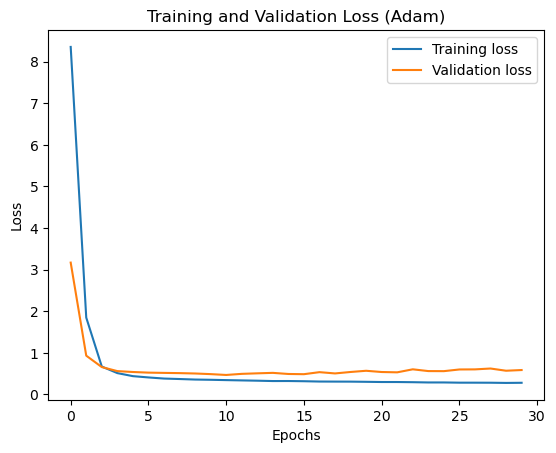

----------------------------------------------------------------------------------------------------


(raylet) [2024-02-21 09:52:58,800 E 72083 203775] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-02-21_09-36-14_670344_71400 is over 95% full, available space: 10919018496; capacity: 245107195904. Object creation will fail if spilling is required.


In [33]:
FMM.plot_history(history, optimizer)

In [3]:
ray.shutdown()